In [1]:
# imports
from pandas.core.internals.blocks import F
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import ipywidgets as wdg  # Using the ipython notebook widgets

In [2]:
# set up RAFT model to get the flow vectors and flow RGB
import os
import sys
import glob
from PIL import Image
sys.path.append('core')

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

from flow_utils import generate_warped_image, get_color_wheel_distance

DEVICE = 'cuda'

def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)

class Args:
    def __init__(self):
        self.model = 'models/raft-things.pth'
        self.path = '../dataset'
        self.small = False
        self.mixed_precision = False
        self.alternate_corr = False
        self.dropout = False
args = Args()

model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))

model = model.module
model.to(DEVICE)
model.eval()

images = glob.glob(os.path.join(args.path, '*.png')) + \
             glob.glob(os.path.join(args.path, '*.jpg'))

images = sorted(images)
prev_frames = images[:-1]
curr_frames = images[1:]

In [88]:
# select a pair of frames and generate the flow
IDX = 100  # 0-237

with torch.no_grad():
    imfile1, imfile2 = prev_frames[IDX],curr_frames[IDX]
    image1 = load_image(imfile1)
    image2 = load_image(imfile2)

    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)

    _, flow_u_v = model(image1, image2, iters=20, test_mode=True)
    img1 = image1[0].permute(1,2,0).cpu().numpy()
    img2 = image2[0].permute(1,2,0).cpu().numpy()
    flow_u_v = flow_u_v[0].permute(1,2,0).cpu().numpy()

    # map flow to rgb image
    flow_rgb = flow_viz.flow_to_image(flow_u_v)

In [89]:
flow_u_v.shape, flow_rgb.shape

((1024, 1024, 2), (1024, 1024, 3))

Textarea(value='', description='Co-ordinates for ROI:', disabled=True, placeholder='')

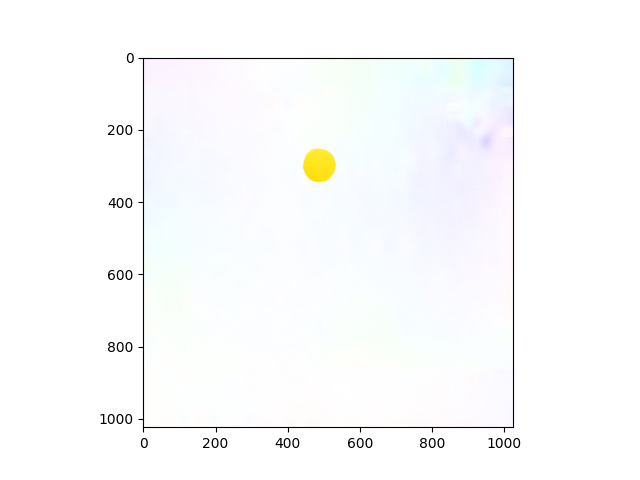

In [90]:
# get a region of interest from a given image
fig = plt.figure()
plt.imshow(flow_rgb)
coord = []

# Create and display textarea widget
txt = wdg.Textarea(
    value='',
    placeholder='',
    description='Co-ordinates for ROI:',
    disabled=True
)
display(txt)

# Define a callback function that will update the textarea
def onclick(event):
    ix, iy = int(event.xdata), int(event.ydata)
    coord.append((ix, iy))
    txt.value = f'x-coordinate:{int(ix)}\ny-coordinate:{int(iy)}'

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)


In [91]:
# plt.close('all')
# print(f'Co-ordinates: {coord}')
# # plot selected region of interest
# roi_flow_rgb = flow_rgb[coord[0][1]:coord[1][1], coord[0][0]:coord[1][0]]
# plt.imshow(roi_flow_rgb)

In [70]:
# print(coord)

# roi_flow_rgb = flow_rgb[coord[0][1]:coord[1][1], coord[0][0]:coord[1][0]]
# roi_flow_u_v = flow_u_v[coord[0][1]:coord[1][1], coord[0][0]:coord[1][0]]

# roi_flow_u_v.shape, roi_flow_rgb.shape

Textarea(value='', description='flow u v:', disabled=True, placeholder='')

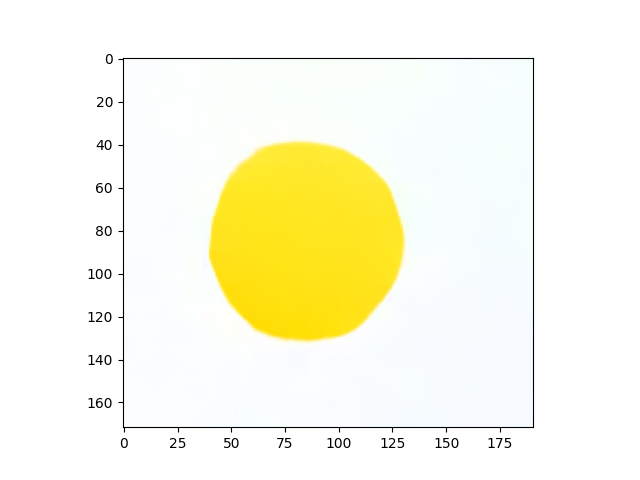

In [92]:
# get the flow vectors from the selected region of interest
plt.close('all')
roi_flow_rgb = flow_rgb[coord[0][1]:coord[1][1], coord[0][0]:coord[1][0]]
roi_flow_u_v = flow_u_v[coord[0][1]:coord[1][1], coord[0][0]:coord[1][0]]
fig = plt.figure()
plt.imshow(roi_flow_rgb/255.0)

# Create and display textarea widget
txt = wdg.Textarea(
    value='',
    placeholder='',
    description='flow u v:',
    disabled=True
)
display(txt)

# Define a callback function that will update the textarea
def onclick(event):
    ix, iy = int(event.xdata), int(event.ydata)
    f = roi_flow_u_v[iy][ix]
    u,v = f[0], f[1]
    txt.value = str(f'u:{round(u,4)}\nv:{round(v,2)}')

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)

Textarea(value='', description='colorwheel:', disabled=True, placeholder='')

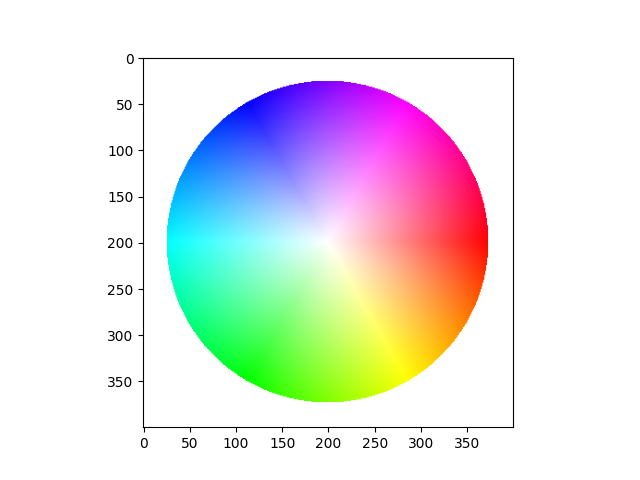

In [81]:
# create an interactive colorwheel
# Below provides the angle and distance from the center (200,200) 
plt.close('all')
COLORWHEEL_PATH = 'images/color_wheel.jpeg'

# Interactive colorwheel on clicking it shows the angle and distance
colorwheel = plt.imread(COLORWHEEL_PATH)
colorwheel = np.rot90(np.rot90(colorwheel))
fig = plt.figure()
plt.imshow(colorwheel)
center_x, center_y = 200,200

# Create and display textarea widget
txt = wdg.Textarea(
    value='',
    placeholder='',
    description='colorwheel:',
    disabled=True
)
display(txt)

def get_degree(x,y):
    deltaY = (center_y-y)**2
    deltaX = (center_x-x)**2
    dist = (deltaX+deltaY)**(1/2)
    radian = math.atan2(deltaY, deltaX)
    deg = radian*(180/math.pi)
    if (center_x-x)>0 and (center_y-y)>0:
        deg = 180-deg
    elif (center_x-x)<0 and (center_y-y)<0:
        deg = 360-deg
    elif (center_y-y)<0:
        deg = 180+deg

    return dist, deg

# Define a callback function that will update the textarea
def onclick(event):
    ix, iy = int(event.xdata), int(event.ydata)
    dist, deg = get_degree(ix, iy)
    txt.value = f'degrees:{round(deg,4)}\ndistance:{round(dist,2)}'

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)
